# Machine Learning Engineer Nanodegree
## Capstone Project
## Predicting Ames Houses

The ultimate goal of this project is to predict how much a house should be solved in Ames, IA.
The problem is a standing [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The dataset contains a list of information for all houses sold in Ames, Iowa from 2006 through 2010. It contains **2930** observations and a large number of explanatory
variables (**23 nominal, 23 ordinal, 14 discrete, and 20 continuous**). Dean De Cook compiled and published this dataset in 2011 and can be found here [here](http://www.amstat.org/publications/jse/v19n3/decock.pdf). 


#### As discussed in the paper, the data is split into training and testing sets. Therefore, in the spirit of the Kaggle competition, I will work on the formats that have been processed and randomly split into 50-50 portions.

### <center> Exploratory Section </center></font>

In [6]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale=2.) 


# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')

# If submitting to Kaggle, load the data required to test predictions.
#data_test = pd.read_csv('test.csv')

# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.keys()



Boston housing dataset has 1460 data points with 81 variables each.
Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'

### <center> Let's start simple. What are the statistical properties of the selling price? </center></font>

In [2]:
# Minimum price of the data
minimum_price = np.min(data.SalePrice)

# Maximum price of the data
maximum_price = np.max(data.SalePrice)

# Mean price of the data
mean_price = np.mean(data.SalePrice)

# Median price of the data
median_price = np.median(data.SalePrice)

# Standard deviation of prices of the data
std_price = np.std(data.SalePrice)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $34,900.00
Maximum price: $755,000.00
Mean price: $180,921.20
Median price $163,000.00
Standard deviation of prices: $79,415.29


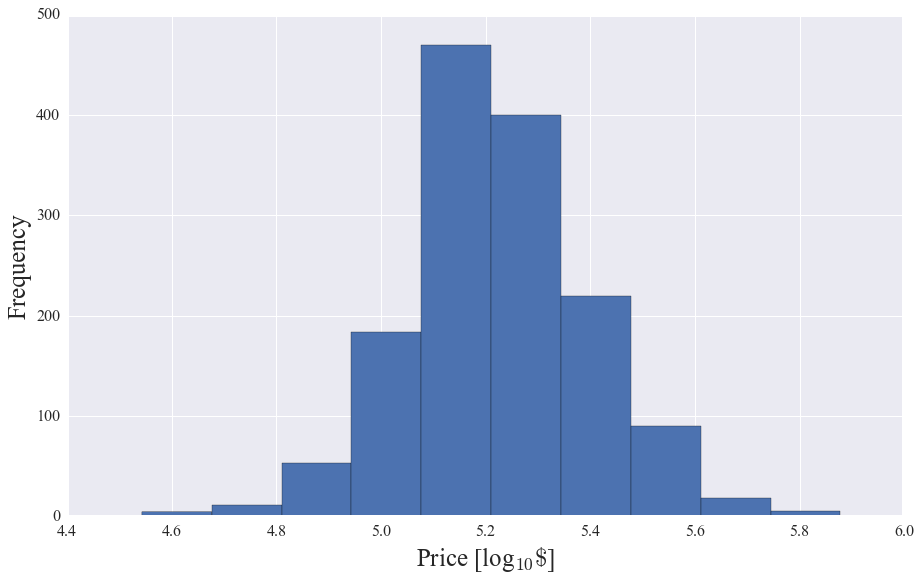

In [9]:
## Let us visualize these results.
log_price = np.log10(data.SalePrice)
plt.hist(log_price)
plt.xlabel('Price '+ r'[log$_{10} \$$]', fontsize = 25)
plt.ylabel('Frequency', fontsize = 25)

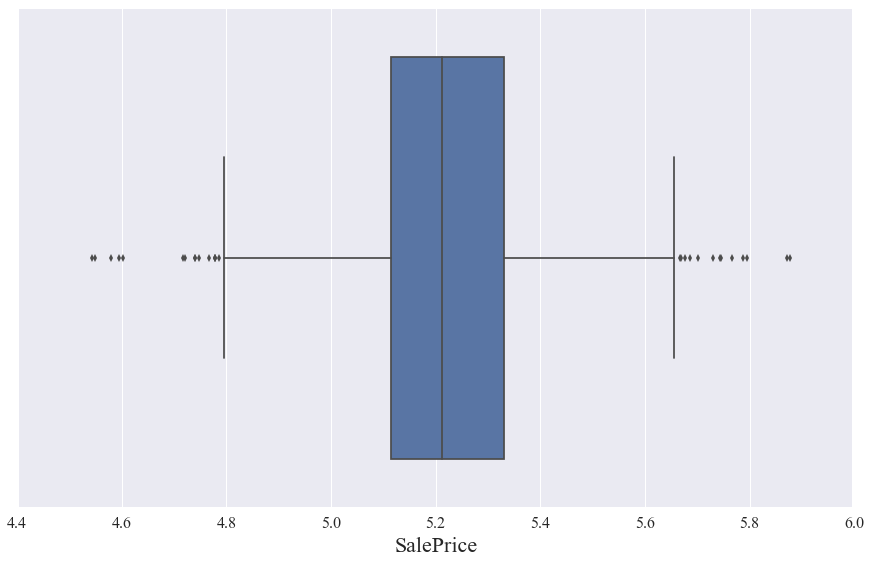

In [10]:
# Box plot: How many outliers are there?
ax = sns.boxplot(x = log_price)

In [37]:
# How many outliers?
# Calculate Q1 (25th percentile of the data) for the given feature
Q1 = np.percentile(log_price, 25)
# Calculate Q3 (75th percentile of the data) for the given feature
Q3 = np.percentile(log_price, 75)
step = 1.5*(Q3-Q1)
print "There are this {} outliers out of a total of {} entries.".format(
    len(log_price[(log_price < Q1 - step)  | (log_price > Q3+step)]), len(data))

There are this 28 outliers out of a total of 1460 entries.


#### Using [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. 

#### Thus, we will remove all these outliers for a more robust regression analysis.

In [38]:
data_clean = data[(log_price >= Q1 - step)  | (log_price <= Q3+step)]
print "Now we will work on "len(data_clean)
data_clean.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
